In [1]:
# Import the necessary libraries
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import KMeans
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Definition of the TSNETransformer to make the grid of t-SNE + Kmeans possible
class TSNETransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=2, **kwargs):
        self.n_components = n_components
        self.kwargs = kwargs
        self.tsne = TSNE(n_components=self.n_components, **self.kwargs)

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.tsne.fit_transform(X)

# Load the data
rail = pd.read_csv('rail.csv', index_col=0)
rail.head()

# Standardize the data
scaler = StandardScaler()
rail_standardized = scaler.fit_transform(rail)

# Divide data into training and test data
X_train, X_test = train_test_split(rail_standardized, test_size=0.2, random_state=42)

# Create pipelines for each combination of t-SNE and KMeans
pipeline = Pipeline([
    ('tsne', TSNETransformer()),
    ('kmeans', KMeans())
])

# Parameters to be searched for each pipeline
param_grid = {
    'tsne__n_components': list(range(2, 5)),
    'kmeans__n_clusters': list(range(2, 7))
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

# Define a scoring function for the silhouette
def silhouette_scorer(estimator, X):
    clusters = estimator.fit_predict(X)
    score = silhouette_score(X, clusters)
    return score

In [3]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5,scoring=silhouette_scorer)

# Training the search grid
grid_search.fit(X_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Meilleurs paramètres :", best_params)

C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default 

Meilleurs paramètres : {'kmeans__n_clusters': 2, 'tsne__n_components': 2}


C:\Users\Dfan\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


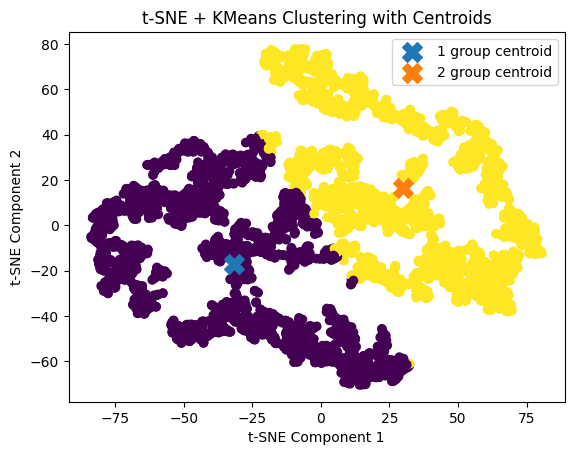

In [4]:
# Extracting the reduced t-SNE components
tsne_components = grid_search.best_estimator_['tsne'].transform(X_train)
clusters_tsne = grid_search.best_estimator_.named_steps['kmeans'].labels_
centroids_tsne = grid_search.best_estimator_.named_steps['kmeans'].cluster_centers_

# Plotting the scatter plot using the t-SNE components
plt.scatter(tsne_components[:, 0], tsne_components[:, 1], c=clusters_tsne, cmap='viridis')
plt.title('t-SNE + KMeans Clustering with Centroids')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')

# Plotting centroids with different colors and creating legend
for i, centroid in enumerate(centroids_tsne):
    plt.scatter(centroid[0], centroid[1], marker='X', s=200, label=f'{i + 1} group centroid')

plt.legend()
plt.show()

Cluster 0:


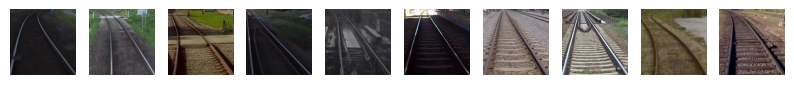

Cluster 1:


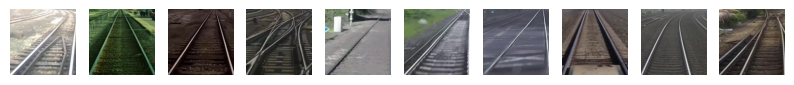

In [7]:
# Path to image folder
image_folder = 'rs19_val_cropped_resized'

# Function to load an image from the file name
def load_image(file_name):
    image_path = os.path.join(image_folder, file_name)
    return Image.open(image_path)

# Get the file names corresponding to the 'rail' DataFrame indexes
image_files = rail.index.astype(str) + '.jpg'

# Predict clusters for the entire data set
clusters = grid_search.predict(rail_standardized)
best_n_clusters = best_params['kmeans__n_clusters']

# Create a dictionary to store image paths for each cluster
cluster_images = {cluster: [] for cluster in range(best_n_clusters)}

# Associate clusters with images
for i, file_name in enumerate(image_files):
    cluster_images[clusters[i]].append(file_name)

# View a sample of images from each cluster
for cluster, images in cluster_images.items():
    print(f"Cluster {cluster}:")
    plt.figure(figsize=(10, 6))
    for i in range(min(len(images), 10)):  # Afficher jusqu'à 10 images de chaque cluster
        image = load_image(images[i])
        plt.subplot(1, 10, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.show()
